# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

### Model 1 : Only to test structure

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D,MaxPooling2D,TimeDistributed,Conv2D
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

class ModelUtility:
    def init(self,batch_size=30,num_epochs=15,image_height=100,image_width=100,start_idx=11,frames_from_seq=15,optimiser="adam"):
        self.train_path = '/home/datasets/Project_data/train'
        self.val_path = '/home/datasets/Project_data/val'
        self.train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
        self.batch_size = batch_size #experiment with the batch size
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)
        self.num_epochs = num_epochs # choose the number of epochs
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.start_idx=start_idx
        self.frames_from_seq=frames_from_seq
        self.optimiser =optimiser
        self.curr_dt_time = datetime.datetime.now()
        self.img_idx=list(range(0,30,2))
        self.frames_from_seq=len(self.img_idx)
        self.print()
        
    def set_img_idx(plist):
        self.img_idx=plist
        self.frames_from_seq=len(self.img_idx)
        
    def print(self):
        print("Batch Size : ",self.batch_size)
        print("image height:",self.image_height,"image width:",self.image_width)
        print("frames from sequence:",self.frames_from_seq)
        print("frames per sequence :",self.img_idx)
        print("num epochs ",self.num_epochs)
        
    
    def prepare_batch(self,source,t,curr_batch,batch_size,img_idx,extraa=0):
        seqlen = extraa if extraa !=0 else batch_size
        batch_data = np.zeros((seqlen,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seqlen,5))
        for folder in range(seqlen):
            imgs = os.listdir(source+'/'+ t[folder + (curr_batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                #image1=cv2.resize(image,(self.image_height,self.image_width))
                
                image = imread(source+'/'+ t[folder + (curr_batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image=resize(image,(self.image_height,self.image_width) )
                batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
            batch_labels[folder, int(t[folder + (curr_batch*batch_size)].strip().split(';')[2])] = 1    
        return batch_data,batch_labels
    
    def generator(self,type):
        source_path=self.train_path if type=="train" else self.val_path
        folder_list=self.train_doc if type=="train" else self.val_doc
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        #img_idx = list(range(self.start_idx,self.start_idx+self.frames_from_seq)) #create a list of image numbers you want to use for a particular video
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // self.batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.prepare_batch(source_path,t,batch,self.batch_size,self.img_idx)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            extraa=len(t)%self.batch_size
            if extraa != 0:
                batch_data, batch_labels= self.prepare_batch(source_path,t,batch,self.batch_size,self.img_idx,extraa)
                yield batch_data, batch_labels


In [6]:
class Conv3DUtility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model=Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, (2, 2, 2), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(128,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
    
        self.model.add(Dense(5,activation='softmax'))
         # "adam" #write your optimizer
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model : just to check whether code working

In [7]:
conv3d=Conv3DUtility()
conv3d.init()
conv3d.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  15
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     4128      
____________________________

In [8]:
conv3d.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.4171 - categorical_accuracy: 0.5324Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2206_36_20.239875/model-00001-1.41708-0.53243-1.74209-0.20000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.4171 - categorical_accuracy: 0.5324 - val_loss: 1.7421 - val_categorical_accuracy: 0.2000
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 0.5559 - categorical_accuracy: 0.8009
Epoch 00002: saving model to model_init_2021-10-2206_36_20.239875/model-00002-0.55585-0.80090-2.53685-0.28000.h5
23/23 [==============================] - 78s 3s/step - loss: 0.5559 - categorical_accuracy: 0.8009 - val_loss: 2.5369 - val_categorical_accuracy: 0.2800
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.3299 - categorical_accuracy: 0.8884
Epoch 00003: sav

KeyboardInterrupt: 

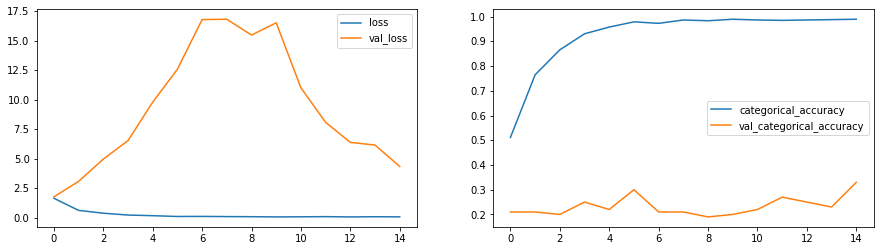

In [31]:
conv3d.plot()

### Model 2 : Expanding the structure (num epochs=15)

### Developing Another Conv3D model

In [7]:
class Conv3D2Utility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model=Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, (2, 2, 2), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, (2, 2, 2), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(128, (2, 2, 2), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        #self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(128,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
    
        self.model.add(Dense(64,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        self.model.add(Dense(5,activation='softmax'))
         # "adam" #write your optimizer
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [21]:
conv3d2=Conv3D2Utility()
conv3d2.init()
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  15
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 50, 50, 32)     4128      
__________________________

In [38]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.7101 - categorical_accuracy: 0.3861Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2018_23_21.084853/model-00001-1.71008-0.38612-2.02247-0.23000.h5
23/23 [==============================] - 76s 3s/step - loss: 1.7101 - categorical_accuracy: 0.3861 - val_loss: 2.0225 - val_categorical_accuracy: 0.2300
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.1188 - categorical_accuracy: 0.5822
Epoch 00002: saving model to model_init_2021-10-2018_23_21.084853/model-00002-1.11875-0.58220-3.35404-0.24000.h5
23/23 [==============================] - 76s 3s/step - loss: 1.1188 - categorical_accuracy: 0.5822 - val_loss: 3.3540 - val_categorical_accuracy: 0.2400
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.9861 - categorical_accuracy: 0.6124
Epoch 00003: sav

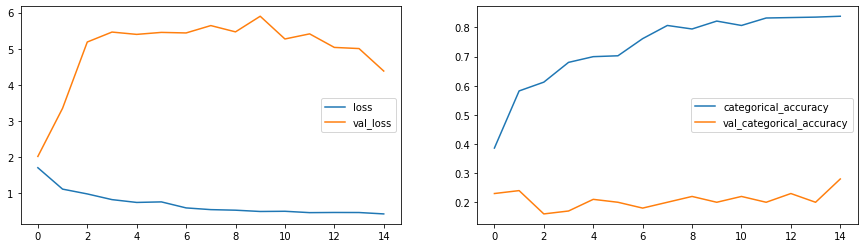

In [39]:
conv3d2.plot()

### Model 3 : increasing number of epochs to 30 (oss: 0.4370 - categorical_accuracy: 0.8326 - val_loss: 0.8239 - val_categorical_accuracy: 0.7300)

In [9]:
conv3d2=Conv3D2Utility()
conv3d2.init(num_epochs=30)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 16
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 5

In [ ]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6309 - categorical_accuracy: 0.4103Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2108_44_48.302226/model-00001-1.63093-0.41026-2.77092-0.16000.h5
23/23 [==============================] - 75s 3s/step - loss: 1.6309 - categorical_accuracy: 0.4103 - val_loss: 2.7709 - val_categorical_accuracy: 0.1600
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0363 - categorical_accuracy: 0.5897
Epoch 00002: saving model to model_init_2021-10-2108_44_48.302226/model-00002-1.03634-0.58974-4.76995-0.16000.h5
23/23 [==============================] - 76s 3s/step - loss: 1.0363 - categorical_accuracy: 0.5897 - val_loss: 4.7699 - val_categorical_accuracy: 0.1600
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.9198 - categorical_accuracy: 0.6576
Epoch 00003: sav

### Model 4 {loss: 0.3394 - categorical_accuracy: 0.8974 - val_loss: 0.7993 - val_categorical_accuracy: 0.7300}

In [15]:
conv3d2=Conv3D2Utility()
conv3d2.init(num_epochs=30)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 16
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 5

In [16]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5979 - categorical_accuracy: 0.4268Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2114_20_13.827390/model-00001-1.59793-0.42685-2.25352-0.16000.h5
23/23 [==============================] - 98s 4s/step - loss: 1.5979 - categorical_accuracy: 0.4268 - val_loss: 2.2535 - val_categorical_accuracy: 0.1600
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1131 - categorical_accuracy: 0.5928
Epoch 00002: saving model to model_init_2021-10-2114_20_13.827390/model-00002-1.11315-0.59276-5.34593-0.16000.h5
23/23 [==============================] - 91s 4s/step - loss: 1.1131 - categorical_accuracy: 0.5928 - val_loss: 5.3459 - val_categorical_accuracy: 0.1600
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.9072 - categorical_accuracy: 0.6335
Epoch 00003: sav

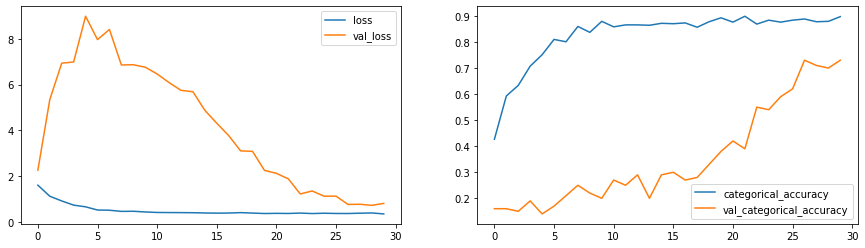

In [21]:
conv3d2.plot()

### Model 4  (categorical_accuracy: 0.9140 - val_loss: 0.5451 - val_categorical_accuracy: 0.8200)
- changed network architecture

In [35]:
class Conv3DSanuUtility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model = Sequential()
        # 1st Layer Group
        self.model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling3D(pool_size=(2,2,2)))


        # 2nd Layer Group
        self.model.add(Conv3D(16, kernel_size=(3,3,3),padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling3D(pool_size=(2,2,2)))

        # 3rd Layer Group
        self.model.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling3D(pool_size=(2,2,2)))

        # FC layer group
        self.model.add(Flatten())
        self.model.add(Dense(512 , activation='relu'))
        self.model.add(Dropout(0.5))

        # Softmax Layer
        self.model.add(Dense(5, activation='softmax'))
        
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [36]:
conv3ds=Conv3DSanuUtility()
conv3ds.init(image_height=80,image_width=80,num_epochs=30)
conv3ds.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 40, 40, 16)     6928      
____________________________

In [37]:
conv3ds.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 4.2741 - categorical_accuracy: 0.2594Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2115_35_25.217794/model-00001-4.27410-0.25943-1.85928-0.19000.h5
23/23 [==============================] - 96s 4s/step - loss: 4.2741 - categorical_accuracy: 0.2594 - val_loss: 1.8593 - val_categorical_accuracy: 0.1900
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3372 - categorical_accuracy: 0.4646
Epoch 00002: saving model to model_init_2021-10-2115_35_25.217794/model-00002-1.33719-0.46456-1.48028-0.41000.h5
23/23 [==============================] - 94s 4s/step - loss: 1.3372 - categorical_accuracy: 0.4646 - val_loss: 1.4803 - val_categorical_accuracy: 0.4100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.0989 - categorical_accuracy: 0.5279
Epoch 00003: sav

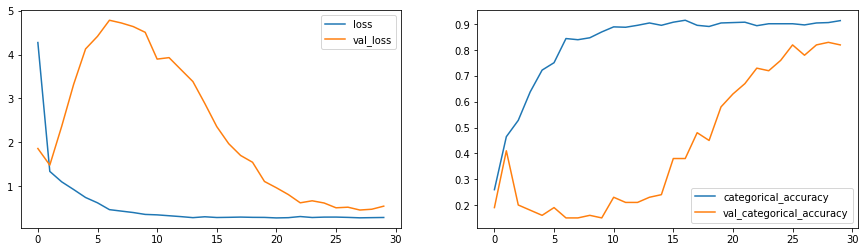

In [38]:
conv3ds.plot()

## Model 5 (loss: 0.3777 - categorical_accuracy: 0.8718 - val_loss: 0.6727 - val_categorical_accuracy: 0.7800)
- with different sized conv filter 
- with lower image size
- with different image index

In [42]:
class Conv3D3Utility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model=Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        

        self.model.add(Flatten())
        self.model.add(Dense(128,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
    
        self.model.add(Dense(64,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        self.model.add(Dense(5,activation='softmax'))
         # "adam" #write your optimizer
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [43]:
conv3d3=Conv3D3Utility()
conv3d3.init(image_height=80,image_width=80,num_epochs=30)
conv3d3.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 7, 40, 40, 32)     13856     
____________________________

In [44]:
conv3d3.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6025 - categorical_accuracy: 0.4585Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2116_50_51.122200/model-00001-1.60250-0.45852-1.56116-0.36000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.6025 - categorical_accuracy: 0.4585 - val_loss: 1.5612 - val_categorical_accuracy: 0.3600
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0616 - categorical_accuracy: 0.5958
Epoch 00002: saving model to model_init_2021-10-2116_50_51.122200/model-00002-1.06163-0.59578-3.91053-0.23000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.0616 - categorical_accuracy: 0.5958 - val_loss: 3.9105 - val_categorical_accuracy: 0.2300
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.8554 - categorical_accuracy: 0.6908
Epoch 00003: sav

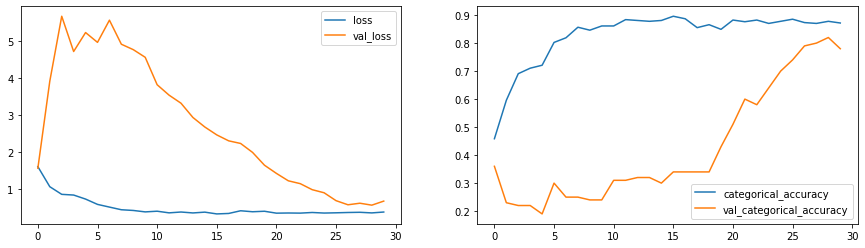

In [45]:
conv3d3.plot()

## Model 6 {loss: 0.0266 - categorical_accuracy: 0.9955 - val_loss: 0.7539 - val_categorical_accuracy: 0.7900}

In [7]:
class Conv3D4Utility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model=Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(32, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        self.model.add(Conv3D(64, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        

        self.model.add(Flatten())
        self.model.add(Dense(512,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
    
        
        
        self.model.add(Dense(5,activation='softmax'))
         # "adam" #write your optimizer
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
conv3d4=Conv3D4Utility()
conv3d4.init(image_height=80,image_width=80,num_epochs=30)
conv3d4.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 40, 40, 32)     13856     
______________________________

In [9]:
conv3d4.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.3855 - categorical_accuracy: 0.5777Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2118_23_40.022908/model-00001-1.38550-0.57768-3.96432-0.20000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.3855 - categorical_accuracy: 0.5777 - val_loss: 3.9643 - val_categorical_accuracy: 0.2000
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.4219 - categorical_accuracy: 0.8386
Epoch 00002: saving model to model_init_2021-10-2118_23_40.022908/model-00002-0.42188-0.83861-10.19325-0.20000.h5
23/23 [==============================] - 75s 3s/step - loss: 0.4219 - categorical_accuracy: 0.8386 - val_loss: 10.1933 - val_categorical_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.2131 - categorical_accuracy: 0.9321
Epoch 00003: s

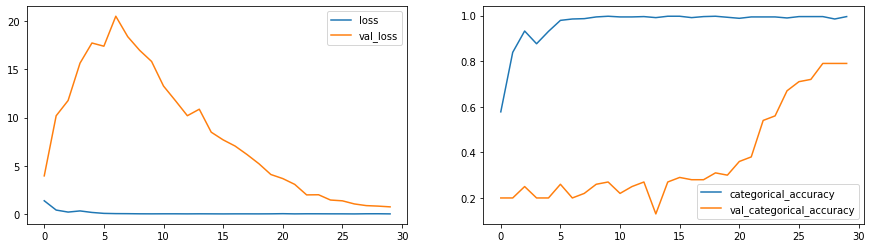

In [10]:
conv3d4.plot()

In [12]:
class Conv3D5Utility(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        self.model=Sequential()
        self.model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv3D(32, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv3D(64, (3, 3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        self.model.add(Dropout(0.5))

        

        self.model.add(Flatten())
        self.model.add(Dense(512,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
    
        
        
        self.model.add(Dense(5,activation='softmax'))
         # "adam" #write your optimizer
        self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        return self.model
    
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [13]:
conv3d5=Conv3D5Utility()
conv3d5.init(image_height=80,image_width=80,num_epochs=30)
conv3d5.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 40, 40, 16)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 40, 40, 16)     0         
____________________________

In [ ]:
conv3d5.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9164 - categorical_accuracy: 0.4404Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2119_09_53.301795/model-00001-1.91635-0.44042-3.55862-0.30000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.9164 - categorical_accuracy: 0.4404 - val_loss: 3.5586 - val_categorical_accuracy: 0.3000
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2425 - categorical_accuracy: 0.5852
Epoch 00002: saving model to model_init_2021-10-2119_09_53.301795/model-00002-1.24252-0.58522-7.73100-0.15000.h5
23/23 [==============================] - 74s 3s/step - loss: 1.2425 - categorical_accuracy: 0.5852 - val_loss: 7.7310 - val_categorical_accuracy: 0.1500
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.8769 - categorical_accuracy: 0.6591
Epoch 00003: sav

## Model (loss: 0.3448 - categorical_accuracy: 0.9050 - val_loss: 0.5345 - val_categorical_accuracy: 0.8400) 

In [23]:
conv3d2=Conv3D2Utility()
conv3d2.init(image_height=120,image_width=120,num_epochs=30)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 120 image width: 120
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_14 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 7, 60, 60, 32)     4128      
__________________________

In [24]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5858 - categorical_accuracy: 0.4465Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2206_54_28.364259/model-00001-1.58583-0.44646-2.86883-0.20000.h5
23/23 [==============================] - 80s 3s/step - loss: 1.5858 - categorical_accuracy: 0.4465 - val_loss: 2.8688 - val_categorical_accuracy: 0.2000
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0149 - categorical_accuracy: 0.6154
Epoch 00002: saving model to model_init_2021-10-2206_54_28.364259/model-00002-1.01488-0.61538-4.72293-0.19000.h5
23/23 [==============================] - 80s 3s/step - loss: 1.0149 - categorical_accuracy: 0.6154 - val_loss: 4.7229 - val_categorical_accuracy: 0.1900
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.8563 - categorical_accuracy: 0.6757
Epoch 00003: sav

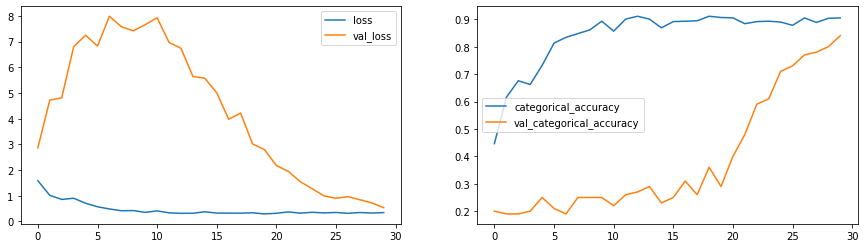

In [25]:
conv3d2.plot()

## Model (loss: 0.1440 - categorical_accuracy: 0.9623 - val_loss: 0.3789 - val_categorical_accuracy: 0.8600)

In [26]:
conv3d2=Conv3D2Utility()
conv3d2.init(image_height=120,image_width=120,num_epochs=30,batch_size=25)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  25
image height: 120 image width: 120
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 7, 60, 60, 32)     4128      
__________________________

In [27]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 1.4926 - categorical_accuracy: 0.4480Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2021-10-2207_37_23.233917/model-00001-1.49263-0.44796-2.50484-0.25000.h5
27/27 [==============================] - 79s 3s/step - loss: 1.4926 - categorical_accuracy: 0.4480 - val_loss: 2.5048 - val_categorical_accuracy: 0.2500
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 0.9715 - categorical_accuracy: 0.6290
Epoch 00002: saving model to model_init_2021-10-2207_37_23.233917/model-00002-0.97147-0.62896-3.88101-0.22000.h5
27/27 [==============================] - 79s 3s/step - loss: 0.9715 - categorical_accuracy: 0.6290 - val_loss: 3.8810 - val_categorical_accuracy: 0.2200
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 0.7741 - categorical_accuracy: 0.7179
Epoch 00003: sav

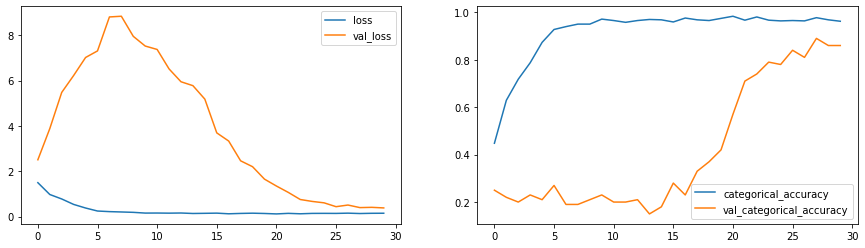

In [28]:
conv3d2.plot()

## Model {loss: 0.0837 - categorical_accuracy: 0.9910 - val_loss: 0.8345 - val_categorical_accuracy: 0.6800}

In [29]:
conv3d2=Conv3D2Utility()
conv3d2.init(image_height=120,image_width=120,num_epochs=30,batch_size=40)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  40
image height: 120 image width: 120
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_22 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 7, 60, 60, 32)     4128      
__________________________

In [30]:
conv3d2.fit()

3
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.4108 - categorical_accuracy: 0.5008Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-10-2208_21_14.432205/model-00001-1.41081-0.50075-1.70965-0.16000.h5
17/17 [==============================] - 79s 5s/step - loss: 1.4108 - categorical_accuracy: 0.5008 - val_loss: 1.7096 - val_categorical_accuracy: 0.1600
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.7080 - categorical_accuracy: 0.7330
Epoch 00002: saving model to model_init_2021-10-2208_21_14.432205/model-00002-0.70801-0.73303-2.53518-0.19000.h5
17/17 [==============================] - 79s 5s/step - loss: 0.7080 - categorical_accuracy: 0.7330 - val_loss: 2.5352 - val_categorical_accuracy: 0.1900
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.4635 - categorical_accuracy: 0.8416
Epoch 00003: sav

## Model (loss: 0.2450 - categorical_accuracy: 0.9231 - val_loss: 0.4280 - val_categorical_accuracy: 0.8200)
- image size (100,100) batch 30

In [31]:
conv3d2=Conv3D2Utility()
conv3d2.init(image_height=100,image_width=100,num_epochs=30)
b.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_26 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 7, 50, 50, 32)     4128      
__________________________

In [33]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6158 - categorical_accuracy: 0.4087Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2209_05_14.194918/model-00001-1.61578-0.40875-2.59172-0.14000.h5
23/23 [==============================] - 81s 4s/step - loss: 1.6158 - categorical_accuracy: 0.4087 - val_loss: 2.5917 - val_categorical_accuracy: 0.1400
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.8077 - categorical_accuracy: 0.7029
Epoch 00002: saving model to model_init_2021-10-2209_05_14.194918/model-00002-0.80765-0.70287-4.41144-0.21000.h5
23/23 [==============================] - 102s 4s/step - loss: 0.8077 - categorical_accuracy: 0.7029 - val_loss: 4.4114 - val_categorical_accuracy: 0.2100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.6825 - categorical_accuracy: 0.7572
Epoch 00003: sa

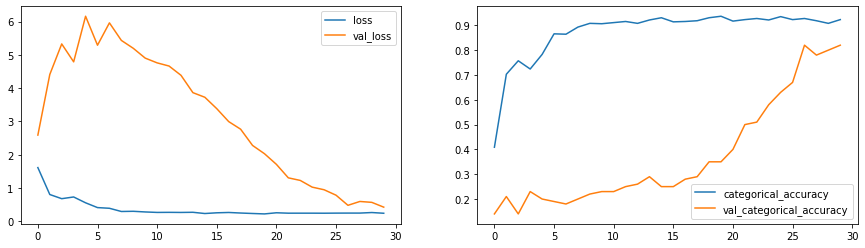

In [34]:
conv3d2.plot()

In [8]:
conv3d2=Conv3D2Utility()
conv3d2.init(image_height=80,image_width=80,num_epochs=30)
conv3d2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 15, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 40, 40, 32)     4128      
______________________________

In [9]:
conv3d2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4390 - categorical_accuracy: 0.4691Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2210_09_46.622829/model-00001-1.43902-0.46908-3.03508-0.16000.h5
23/23 [==============================] - 75s 3s/step - loss: 1.4390 - categorical_accuracy: 0.4691 - val_loss: 3.0351 - val_categorical_accuracy: 0.1600
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.8317 - categorical_accuracy: 0.6772
Epoch 00002: saving model to model_init_2021-10-2210_09_46.622829/model-00002-0.83173-0.67722-5.84705-0.16000.h5
23/23 [==============================] - 78s 3s/step - loss: 0.8317 - categorical_accuracy: 0.6772 - val_loss: 5.8471 - val_categorical_accuracy: 0.1600
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.5924 - categorical_accuracy: 0.7858
Epoch 00003: sav

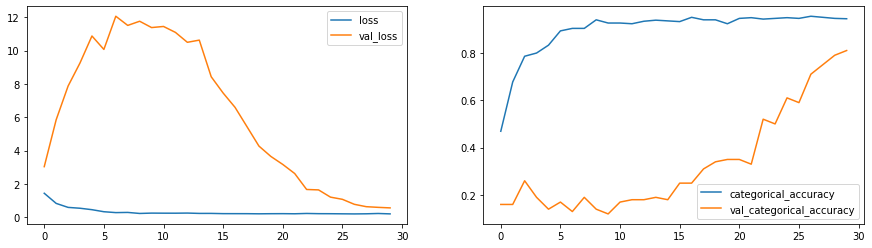

In [10]:
conv3d2.plot()

## Model (CNNLSTM) {categorical_accuracy: 0.8763 - val_loss: 0.7506 - val_categorical_accuracy: 0.7100 }

In [9]:
class CNNLSTM1(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        
        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Flatten()))
                  
        self.model.add(LSTM(64))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(64,activation='relu'))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        
        return self.model
        

        
        
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [10]:
cnnlstm1=CNNLSTM1()
cnnlstm1.init(num_epochs=30)
cnnlstm1.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 50, 50, 32)    128       
__________________________

In [11]:
cnnlstm1.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5119 - categorical_accuracy: 0.2971Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2412_04_20.311166/model-00001-1.51191-0.29713-1.62865-0.23000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.5119 - categorical_accuracy: 0.2971 - val_loss: 1.6286 - val_categorical_accuracy: 0.2300
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3166 - categorical_accuracy: 0.4600
Epoch 00002: saving model to model_init_2021-10-2412_04_20.311166/model-00002-1.31660-0.46003-1.59925-0.23000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.3166 - categorical_accuracy: 0.4600 - val_loss: 1.5993 - val_categorical_accuracy: 0.2300
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1814 - categorical_accuracy: 0.5113
Epoch 00003: sav

## Model CNNLSTM2 {loss: 0.3675 - categorical_accuracy: 0.9005 - val_loss: 0.7582 - val_categorical_accuracy: 0.7500}

In [13]:
class CNNLSTM2(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        
        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Flatten()))
                  
        self.model.add(LSTM(64))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(64,activation='relu'))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        
        return self.model
        

        
        
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [14]:
cnnlstm2=CNNLSTM2()
cnnlstm2.init(num_epochs=30)
cnnlstm2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 50, 50, 32)    128       
__________________________

In [15]:
cnnlstm2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4783 - categorical_accuracy: 0.3348Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2418_16_36.850228/model-00001-1.47830-0.33484-1.68394-0.29000.h5
23/23 [==============================] - 74s 3s/step - loss: 1.4783 - categorical_accuracy: 0.3348 - val_loss: 1.6839 - val_categorical_accuracy: 0.2900
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2643 - categorical_accuracy: 0.4736
Epoch 00002: saving model to model_init_2021-10-2418_16_36.850228/model-00002-1.26433-0.47360-1.74561-0.23000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.2643 - categorical_accuracy: 0.4736 - val_loss: 1.7456 - val_categorical_accuracy: 0.2300
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1354 - categorical_accuracy: 0.5415
Epoch 00003: sav

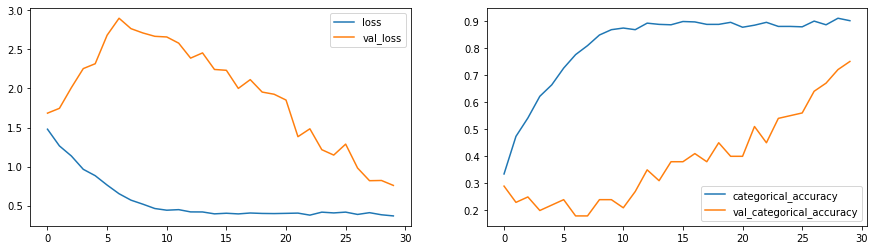

In [16]:
cnnlstm2.plot()

## Model {loss: 0.1975 - categorical_accuracy: 0.9487 - val_loss: 0.6148 - val_categorical_accuracy: 0.7900}
- with image height = 70 and image width =70

In [19]:
cnnlstm3=CNNLSTM2()
cnnlstm3.init(image_height=70,image_width=70,num_epochs=30)
cnnlstm3.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 70 image width: 70
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_60 (TimeDis (None, 15, 70, 70, 16)    448       
_________________________________________________________________
time_distributed_61 (TimeDis (None, 15, 70, 70, 16)    64        
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 35, 35, 16)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 35, 35, 32)    4640      
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 35, 35, 32)    128       
____________________________

In [20]:
cnnlstm3.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4943 - categorical_accuracy: 0.3590Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2418_59_05.411805/model-00001-1.49432-0.35897-1.64091-0.23000.h5
23/23 [==============================] - 74s 3s/step - loss: 1.4943 - categorical_accuracy: 0.3590 - val_loss: 1.6409 - val_categorical_accuracy: 0.2300
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2817 - categorical_accuracy: 0.4646
Epoch 00002: saving model to model_init_2021-10-2418_59_05.411805/model-00002-1.28169-0.46456-1.66097-0.27000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.2817 - categorical_accuracy: 0.4646 - val_loss: 1.6610 - val_categorical_accuracy: 0.2700
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1228 - categorical_accuracy: 0.5566
Epoch 00003: sav

## Model (CNNGRU) {loss: 0.3674 - categorical_accuracy: 0.8869 - val_loss: 0.7947 - val_categorical_accuracy: 0.7600}

In [4]:
class CNNGRU1(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        
        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Flatten()))
                  
        self.model.add(GRU(64))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(64,activation='relu'))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        
        return self.model
        

        
        
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [5]:
cnngru1=CNNGRU1()
cnngru1.init(num_epochs=30)
cnngru1.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    128       
____________________________

In [6]:
cnngru1.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5958 - categorical_accuracy: 0.3122Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2506_05_12.088453/model-00001-1.59584-0.31222-1.94843-0.18000.h5
23/23 [==============================] - 70s 3s/step - loss: 1.5958 - categorical_accuracy: 0.3122 - val_loss: 1.9484 - val_categorical_accuracy: 0.1800
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2159 - categorical_accuracy: 0.5038
Epoch 00002: saving model to model_init_2021-10-2506_05_12.088453/model-00002-1.21592-0.50377-2.70511-0.17000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.2159 - categorical_accuracy: 0.5038 - val_loss: 2.7051 - val_categorical_accuracy: 0.1700
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.0578 - categorical_accuracy: 0.5732
Epoch 00003: sav

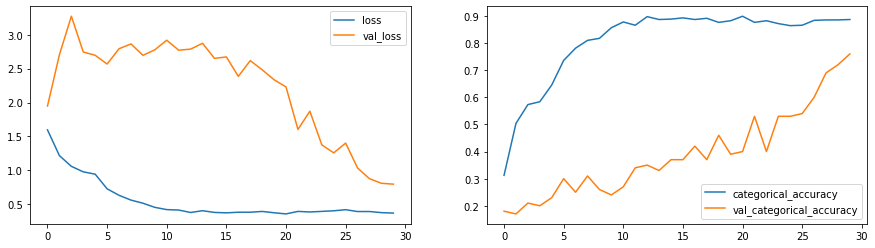

In [8]:
cnngru1.plot()

## Model (CNNGRU ) {loss: 0.2257 - categorical_accuracy: 0.9412 - val_loss: 0.7890 - val_categorical_accuracy: 0.6400}
- heigh 80 width 80

In [10]:
cnngru3=CNNGRU1()
cnngru3.init(image_height=80,image_width=80,num_epochs=30)
cnngru3.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 80 image width: 80
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 80, 80, 16)    448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 80, 80, 16)    64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 40, 40, 32)    128       
____________________________

In [11]:
cnngru3.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4431 - categorical_accuracy: 0.3529Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2506_58_49.962087/model-00001-1.44306-0.35294-1.68101-0.15000.h5
23/23 [==============================] - 71s 3s/step - loss: 1.4431 - categorical_accuracy: 0.3529 - val_loss: 1.6810 - val_categorical_accuracy: 0.1500
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1824 - categorical_accuracy: 0.4766
Epoch 00002: saving model to model_init_2021-10-2506_58_49.962087/model-00002-1.18239-0.47662-1.99211-0.19000.h5
23/23 [==============================] - 70s 3s/step - loss: 1.1824 - categorical_accuracy: 0.4766 - val_loss: 1.9921 - val_categorical_accuracy: 0.1900
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.0155 - categorical_accuracy: 0.6124
Epoch 00003: sav

## Model (CNNGRU) {loss: 0.2540 - categorical_accuracy: 0.9321 - val_loss: 0.7494 - val_categorical_accuracy: 0.7500}
- height : 120 width:120

In [6]:
cnngru4=CNNGRU1()
cnngru4.init(image_height=120,image_width=120,num_epochs=30)
cnngru4.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 120 image width: 120
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 32)    128       
____________________________

In [7]:
cnngru4.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4831 - categorical_accuracy: 0.3348Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2515_26_17.850838/model-00001-1.48313-0.33484-1.85763-0.21000.h5
23/23 [==============================] - 77s 3s/step - loss: 1.4831 - categorical_accuracy: 0.3348 - val_loss: 1.8576 - val_categorical_accuracy: 0.2100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1107 - categorical_accuracy: 0.5520
Epoch 00002: saving model to model_init_2021-10-2515_26_17.850838/model-00002-1.11065-0.55204-2.24707-0.20000.h5
23/23 [==============================] - 80s 3s/step - loss: 1.1107 - categorical_accuracy: 0.5520 - val_loss: 2.2471 - val_categorical_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.9828 - categorical_accuracy: 0.6018
Epoch 00003: sav

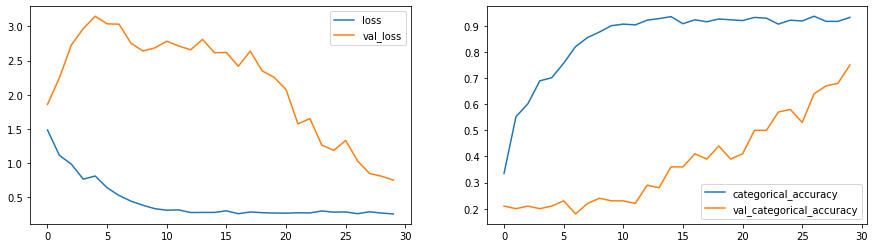

In [9]:
cnngru4.plot()

## Model (CNNGRU) {oss: 0.3476 - categorical_accuracy: 0.8899 - val_loss: 0.5516 - val_categorical_accuracy: 0.7800}

In [11]:
cnngru5=CNNGRU1()
cnngru5.init(num_epochs=40)
cnngru5.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  40
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 50, 50, 32)    128       
__________________________

In [12]:
cnngru5.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5446 - categorical_accuracy: 0.3590Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2516_17_04.565013/model-00001-1.54462-0.35897-1.73029-0.23000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.5446 - categorical_accuracy: 0.3590 - val_loss: 1.7303 - val_categorical_accuracy: 0.2300
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.2415 - categorical_accuracy: 0.4917
Epoch 00002: saving model to model_init_2021-10-2516_17_04.565013/model-00002-1.24152-0.49170-2.06768-0.27000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.2415 - categorical_accuracy: 0.4917 - val_loss: 2.0677 - val_categorical_accuracy: 0.2700
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.0981 - categorical_accuracy: 0.5385
Epoch 00003: sav

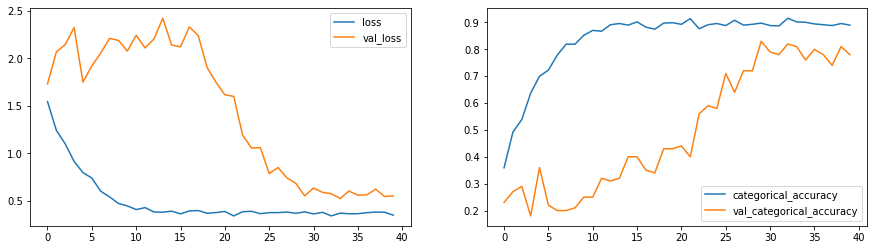

In [13]:
cnngru5.plot()

## Model 18  {loss: 0.4729 - categorical_accuracy: 0.8446 - val_loss: 0.7926 - val_categorical_accuracy: 0.7300}


In [6]:
class CNNGRU2(ModelUtility):
    def buildModel(self):
        input_shape = (self.frames_from_seq,self.image_height,self.image_width,self.channels)
        
        self.model = Sequential()

        self.model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=input_shape))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        self.model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        self.model.add(TimeDistributed(BatchNormalization()))
        self.model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        
        self.model.add(TimeDistributed(Flatten()))
                  
        self.model.add(GRU(64))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(64,activation='relu'))
        self.model.add(Dropout(.25))
        
        self.model.add(Dense(5, activation='softmax'))
        optimiser = optimizers.Adam()
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print (self.model.summary())
        
        return self.model
        

        
        
    def fit(self):
        model_name = 'model_init' + '_' + str(self.curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
                 # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
            print(validation_steps)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            print(validation_steps)
        
        train_generator = self.generator(type="train")
        val_generator = self.generator(type="val")
        self.history=self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [7]:
cnngru2=CNNGRU2()
cnngru2.init(num_epochs=30)
cnngru2.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    128       
____________________________

In [8]:
cnngru2.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5160 - categorical_accuracy: 0.3544Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2705_41_47.254715/model-00001-1.51601-0.35445-1.78889-0.19000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.5160 - categorical_accuracy: 0.3544 - val_loss: 1.7889 - val_categorical_accuracy: 0.1900
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2784 - categorical_accuracy: 0.4646
Epoch 00002: saving model to model_init_2021-10-2705_41_47.254715/model-00002-1.27838-0.46456-2.33065-0.18000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.2784 - categorical_accuracy: 0.4646 - val_loss: 2.3306 - val_categorical_accuracy: 0.1800
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1691 - categorical_accuracy: 0.5008
Epoch 00003: sav

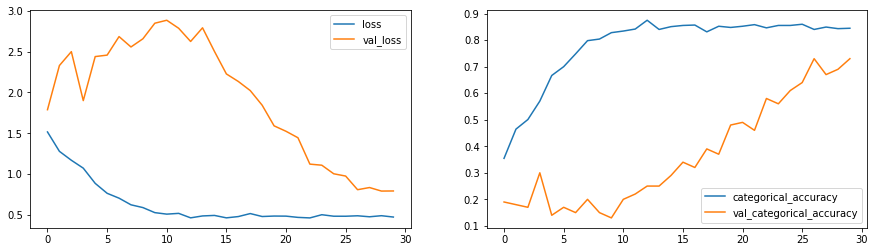

In [10]:
cnngru2.plot()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model (Discard)

In [11]:
cnngru3=CNNGRU2()
cnngru3.init(num_epochs=40)
cnngru3.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 100 image width: 100
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  40
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 50, 50, 32)    128       
__________________________

In [12]:
cnngru3.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5085 - categorical_accuracy: 0.3424Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2706_31_44.650885/model-00001-1.50845-0.34238-1.69303-0.17000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.5085 - categorical_accuracy: 0.3424 - val_loss: 1.6930 - val_categorical_accuracy: 0.1700
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.2792 - categorical_accuracy: 0.4449
Epoch 00002: saving model to model_init_2021-10-2706_31_44.650885/model-00002-1.27921-0.44495-1.60266-0.20000.h5
23/23 [==============================] - 90s 4s/step - loss: 1.2792 - categorical_accuracy: 0.4449 - val_loss: 1.6027 - val_categorical_accuracy: 0.2000
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.1048 - categorical_accuracy: 0.5324
Epoch 00003: sav

## Model19 : (CNNGRU) {loss: 0.6142 - categorical_accuracy: 0.7828 - val_loss: 0.7408 - val_categorical_accuracy: 0.7300}

In [13]:
cnngru4=CNNGRU2()
cnngru4.init(image_height=160,image_width=160,num_epochs=40)
cnngru4.buildModel()

# training sequences = 663
# validation sequences = 100
Batch Size :  30
image height: 160 image width: 160
frames from sequence: 15
frames per sequence : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
num epochs  40
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 15, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 15, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 80, 80, 32)    128       
__________________________

In [14]:
cnngru4.fit()

4
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5127 - categorical_accuracy: 0.3514Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-10-2707_36_21.347744/model-00001-1.51267-0.35143-1.81984-0.25000.h5
23/23 [==============================] - 103s 4s/step - loss: 1.5127 - categorical_accuracy: 0.3514 - val_loss: 1.8198 - val_categorical_accuracy: 0.2500
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.2078 - categorical_accuracy: 0.5038
Epoch 00002: saving model to model_init_2021-10-2707_36_21.347744/model-00002-1.20779-0.50377-1.93396-0.21000.h5
23/23 [==============================] - 102s 4s/step - loss: 1.2078 - categorical_accuracy: 0.5038 - val_loss: 1.9340 - val_categorical_accuracy: 0.2100
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.0998 - categorical_accuracy: 0.5309
Epoch 00003: s

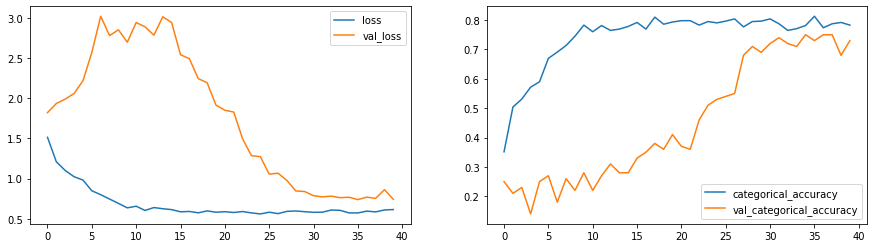

In [16]:
cnngru4.plot()